# Analysing Binding Data from the ChEMBL database

## Getting familiar with the data

Go to the ChEMBL database `https://www.ebi.ac.uk/chembl/` and search for `cAMP-dependent protein kinase`. Look for entry `CHEMBL2094138` and click on it. Scroll down to `Ligand Efficiencies` and click on `See all bioactivities for target CHEMBL2094138 used in this visualisation`. Look at the statistics displayed on the left of the website and answer the following questions.

1.) Explain the trend in the histogram "max phase".

2.) Just by looking at the structures of the known binders, can you identify some common substructures?

## Querying Binders for our Target

We will now download the data from ChEMBL relevant to our target, which iscAMP-dependent protein kinase. Run the cell below to get a list with activity data for `CHEMBL2094138`. We are querying the database only for IC50 values. We will standardize and filter the data and finally convert IC50 to pIC50 (which is -log10(IC50))

1.) What is an IC50 value?

2.) What other types of activity measures do you know?

In [ ]:
from chembl_webresource_client.new_client import new_client

compounds_api = new_client.molecule
bioactivities_api = new_client.activity

bioactivities = bioactivities_api.filter(
    target_chembl_id="CHEMBL2094138",
    type="IC50", relation="=", assay_type="B"
    ).only(
        "activity_id", "assay_chembl_id", "assay_description", "assay_type",
        "molecule_chembl_id", "type", "standard_units", "relation", "standard_value",
        "target_chembl_id", "target_organism",
    )

import pandas as pd
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
### Remove units
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
### Remove duplicates
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
### Rename columns
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
### Make sure that IC50 values have data type float64
bioactivities_df = bioactivities_df.astype({"IC50": "float64"})
### Convert IC50 to pIC50
import math
bioactivities_df["pIC50"] = bioactivities_df.apply(lambda x: 9 - math.log10(x.IC50), axis=1)

## Getting an overview of the data

It is always a good idea to just look at the idea and try to make sense of it before using advanced tools. A very good initial thing to do is to histogram the data. Run the cell below to get histogram for IC50 and pIC50.

1.) When comparing the histogram plots for `IC50` and `pIC50`, what is the difference?

2.) Why would it be a good idea to use the `pIC50` istead of `IC50` for predictive modelling?

3.) Plot the histograms below again, but this time set `density=False` in order to get the frequencies instead of the densities of the data. Explain what the difference between these two are. Which one, frequency or density, should we use here?

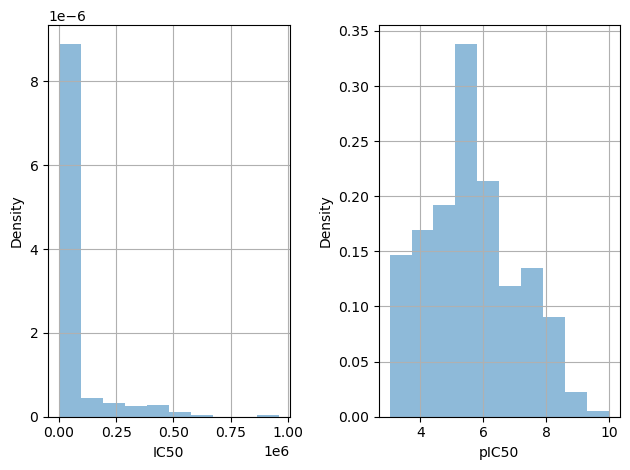

In [16]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2)
bioactivities_df["IC50"].hist(alpha=0.5, ax=axs[0], density=True)
bioactivities_df["pIC50"].hist(alpha=0.5, ax=axs[1], density=True)
axs[0].set_xlabel("IC50")
axs[1].set_xlabel("pIC50")
axs[0].set_ylabel("Density")
axs[1].set_ylabel("Density")
fig.tight_layout()

## Querying chemical information about the Binders

In the next step, we will query more detailed information about the binding molecules. Specifically, we want to know the chemical structures of the molecules so that we can try to learn from them. This is achieved by obtaining the SMILES for each of the molecules.

1.) What is a SMILES of a molecule?

2.) How is SMILES different from a three-dimensional representation of the molecule?

In [ ]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")
compounds = list(compounds_provider)
compounds_df = pd.DataFrame.from_records(
    compounds,
)

canonical_smiles = []
for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
compounds_df.dropna(axis=0, how="any", inplace=True)
compounds_df.head()

## Merging the database with chemical information and the one with binding data

In a final step, we will merge the two databases. After that we are ready to work with the data. We also save a copy of our data to disk as a `.csv` file.

In [ ]:
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "pIC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)
output_df.to_csv("binders.csv")
output_df.head()

## Inspect the Structures

Next, we want to look at the 2D structures of the molecules. We will now generate 2D depictions of the molecules to get an idea of their structure.

1.) Modify the indices in `molecules.loc` at the bottom of the cell below to query different structures. Try to find a pair of binders that look similar but have different IC50/pIC50 values.

In [ ]:
from rdkit.Chem import Descriptors, Draw, PandasTools
molecules = pd.DataFrame(
    {"molecule_chembl_id"   : output_df["molecule_chembl_id"], 
     "smiles" : output_df["smiles"],
     "pIC50"  : output_df["pIC50"],
    }
)
PandasTools.RenderImagesInAllDataFrames(images=True)
PandasTools.AddMoleculeColumnToFrame(molecules, "smiles", includeFingerprints=True)
molecules.loc[[3,4]]

## Rule-of-Five (RO5) and Druglikeliness

Next, we will compute RO5 properties of our molecules.

1.) What is RO5 and what is it used for?

2.) Given the pair you found in the previous step, do they differ in their RO5 values?

In [17]:
import helpers
ro5_properties = molecules["smiles"].apply(helpers.calculate_ro5_properties)
ro5_properties.loc[[3,4]]

/home/tb/tohuefne/progs/miniconda3/envs/cadd-course/lib/python3.12/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,molecular_weight,n_hba,n_hbd,logp,N_rot_bonds,ro5_fulfilled
3,341.116427,3,2,3.2268,2,True
4,270.111676,4,4,0.0837,4,True


## Ro5 Radar Plots

Next, we will plot the mean +/- std of each Ro5 value in a radar plot.

1.) Try to get familiar with a radar plot and understand what is displayed here.

2.) Explain what you see in these plots. What does it tell you about the molecules in our dataset?

In [18]:
molecules_ro5_fulfilled = ro5_properties[ro5_properties["ro5_fulfilled"]]
molecules_ro5_violated  = ro5_properties[~ro5_properties["ro5_fulfilled"]]

molecules_ro5_fulfilled_stats = helpers.calculate_mean_std(
    molecules_ro5_fulfilled[["molecular_weight", "n_hba", "n_hbd", "logp", "N_rot_bonds"]]
)
molecules_ro5_violated_stats = helpers.calculate_mean_std(
    molecules_ro5_violated[["molecular_weight", "n_hba", "n_hbd", "logp", "N_rot_bonds"]]
)

thresholds = {"molecular_weight": 500, "n_hba": 5, "n_hbd": 5, "logp": 5, "N_rot_bonds" : 10}
scaled_threshold = 5
properties_labels = [
    "Molecular weight (Da) / 100",
    "# HBA",
    "# HBD",
    "LogP",
    "Number of rotatable bonds / 2"
]

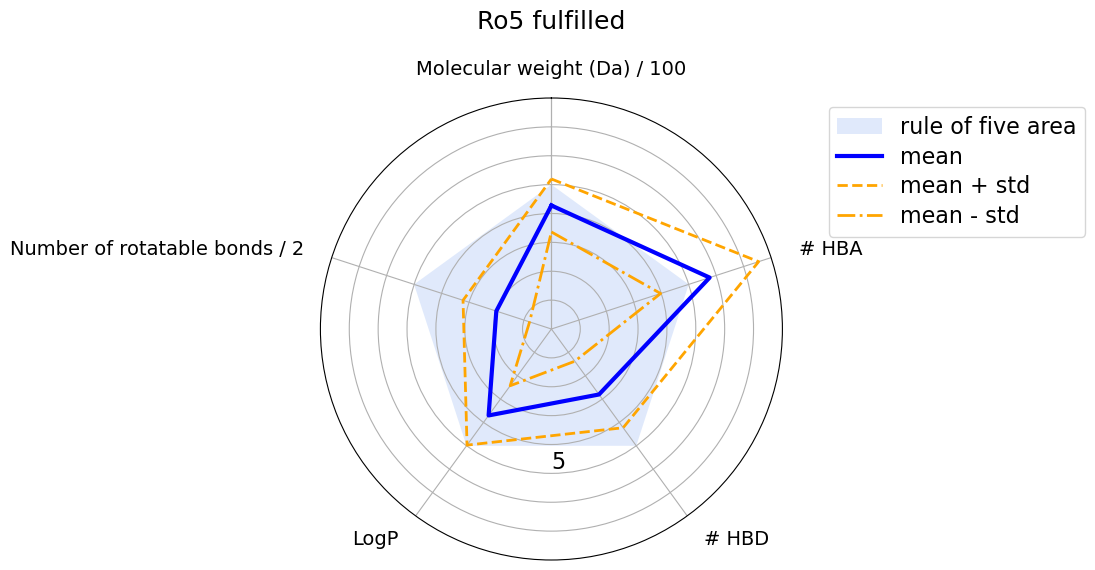

In [19]:
helpers.plot_radar(
    molecules_ro5_fulfilled_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    title = "Ro5 fulfilled",
    y_max = 8,
)

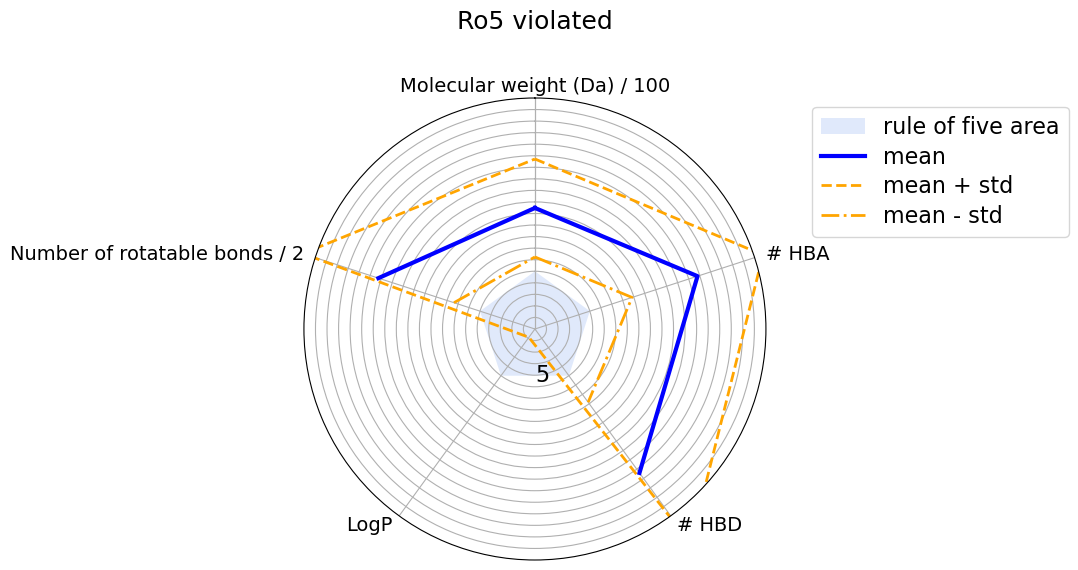

In [20]:
helpers.plot_radar(
    molecules_ro5_violated_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    title = "Ro5 violated",
    y_max = 20,
)

## Conclusion

Very good, you reached the end of the notebook. Now that we have gathered all the data and have a good sense for how the data looks, we will move on to the next part: Predictive Modelling.